In [1]:
%matplotlib inline

In [2]:
import os
import urllib
import numpy as np
from os import listdir
from os.path import isfile, join
from scipy import misc
import random

import tensorflow as tf
from tensorflow.python.ops.constant_op import constant
from tensorflow.models.rnn import rnn, rnn_cell
import numpy as np

In [3]:
import random as rand

def extract_images_labels(folder_name):
    images = [f for f in listdir(folder_name) if isfile(join(folder_name, f)) and f.endswith('png')]
    rand.shuffle(images)
    lbs = np.zeros((len(images), 10))
    counter = 0
    for image in images:
        vals = np.zeros(10)
        vals[int(image[0])] = 1
        lbs[counter,:] = vals
        counter += 1
    return images, lbs;

In [4]:
folder_name = "/home/agah/TF/CSE253Project/spoken_numbers"

In [5]:
img_paths, img_labels = extract_images_labels(folder_name);

assert len(img_paths) == len(img_labels)
index = random.randint(0,len(img_paths)-1)
print index
print img_paths[index]
print img_labels[index]

total_number_of_images = len(img_paths);
print "Total # of images", total_number_of_images

352
5_Samantha_280.wav.png
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
Total # of images 4684


In [6]:
class DataSet(object):
    def __init__(self, images, labels):
        assert len(images) == len(labels), (
          "images.shape: %s labels.shape: %s" % (len(images), len(labels)))
        self._num_examples = len(images)

        self._images = np.asarray(images)
        self._labels = np.asarray(labels)
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images
    
    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size, fake_data=False):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]

In [7]:
tr_size = int(0.95 * total_number_of_images)
te_size = total_number_of_images - tr_size

In [8]:
def read_data_sets(train_dir):
    class DataSets(object):
        pass
    
    data_sets = DataSets()
    images, labels = extract_images_labels(train_dir)

    train_images = images[:tr_size]
    train_labels = labels[:tr_size]
    
    test_images = images[tr_size:]
    test_labels = labels[tr_size:]

    print len(train_images), len(train_labels)
    print len(test_images), len(test_labels)

    data_sets.train = DataSet(train_images, train_labels)
    data_sets.test = DataSet(test_images, test_labels)
    
    return data_sets

In [9]:
data = read_data_sets(folder_name)

print("data returned")

4449 4449
235 235
data returned


In [10]:
'''
Every image row is a sequence of pixels, so 512 sequences of 512 steps for every input
'''

learning_rate = 0.001
training_iters = 100 * 1280
batch_size = 128
display_step = 10

In [11]:
# Network Parameters
n_input = 512 # 512*512 images
n_steps = 512 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # Total classes (0-9 digits)

In [12]:
# Input
x = tf.placeholder("float", [None, n_steps, n_input])

# Requires 2x n_hidden length (state & cell)
istate_fw = tf.placeholder("float", [None, 2*n_hidden])
istate_bw = tf.placeholder("float", [None, 2*n_hidden])
y = tf.placeholder("float", [None, n_classes])

In [13]:
# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of foward + backward cells
    'hidden': tf.Variable(tf.random_normal([n_input, 2*n_hidden])),
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([2*n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

w_hidden_hist = tf.histogram_summary("hidden weights", weights['hidden'])
w_out_hist = tf.histogram_summary("output weights", weights['out'])
b_hidden_hist = tf.histogram_summary("hidden biases", biases['hidden'])
b_out_hist =  tf.histogram_summary("output biases", biases['out'])

In [14]:
def BidirectionalRNN(_X, _istate_fw, _istate_bw, _weights, _biases, _batch_size, _seq_len):

    _seq_len = tf.fill([_batch_size], constant(_seq_len, dtype=tf.int64))
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden'] # Linear Activation

    # Forward cellx`
    lstm_fw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
    # Backward cell
    lstm_bw_cell = rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Split data
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # cell output
    outputs = rnn.bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, _X,
                                            initial_state_fw=_istate_fw,
                                            initial_state_bw=_istate_bw,
                                            sequence_length=_seq_len)

    # Linear activation
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']

In [15]:
print("Calling BidirectionalRNN")
pred = BidirectionalRNN(x, istate_fw, istate_bw, weights, biases, batch_size, n_steps)
print("BidirectionalRNN Done")

Calling BidirectionalRNN
BidirectionalRNN Done


In [16]:
# loss and optimizer
with tf.name_scope("cost") as scope:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
    cost_summary = tf.scalar_summary("cost", cost)

with tf.name_scope("optimizer") as scope:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

In [17]:
# Evaluate model
with tf.name_scope("prediction") as scope:
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))

with tf.name_scope("accuracy") as scope:
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    accuracy_summary = tf.scalar_summary("accuracy", accuracy)


In [18]:
# Initializing the variables
init = tf.initialize_all_variables()

In [19]:
def get_images(image_paths):
    rets = np.zeros((len(image_paths), 512, 512))
    counter = 0
    for image in image_paths:
        img_data = misc.imread(join(folder_name, image))
        rets[counter][:] = img_data
        counter += 1

    images = rets.reshape(rets.shape[0], rets.shape[1] * rets.shape[2])
    
    # Convert from [0, 255] -> [0.0, 1.0].
    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)
    
    return images

In [20]:
print("Run the session...")
# Launch the graph
accs = np.zeros(training_iters / batch_size / display_step)
losses = np.zeros(training_iters / batch_size / display_step)
iterations = np.zeros(training_iters / batch_size / display_step)
testaccs = np.zeros(training_iters / batch_size / display_step)


with tf.Session() as sess:
    sess.run(init)
    
    writer = tf.train.SummaryWriter("/tmp/tf1", sess.graph_def)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs_paths, batch_ys = data.train.next_batch(batch_size)
        batch_xs = get_images(batch_xs_paths)
        
        # Reshape data to get 28 seq of 28 elements
        batch_xs = batch_xs.reshape((batch_size, n_steps, n_input))
        
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys,
                                       istate_fw: np.zeros((batch_size, 2*n_hidden)),
                                       istate_bw: np.zeros((batch_size, 2*n_hidden))})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys,
                                                istate_fw: np.zeros((batch_size, 2*n_hidden)),
                                                istate_bw: np.zeros((batch_size, 2*n_hidden))})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys,
                                             istate_fw: np.zeros((batch_size, 2*n_hidden)),
                                             istate_bw: np.zeros((batch_size, 2*n_hidden))})
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) + \
                  ", Training Accuracy= " + "{:.5f}".format(acc)
                
            accs[step / display_step] = acc
            losses[step / display_step] = loss
            iterations[step / display_step] = step * batch_size

            test_len = 128
            test_images = get_images(data.test.images[:test_len])
            test_data = test_images.reshape((-1, n_steps, n_input))
            test_label = data.test.labels[:test_len]
            testaccs_tmp = sess.run(accuracy, feed_dict={x: test_data, y: test_label,
                                                     istate_fw: np.zeros((test_len, 2*n_hidden)),
                                                     istate_bw: np.zeros((test_len, 2*n_hidden))}) 
            testaccs[step / display_step] = testaccs_tmp
        step += 1
        
    print "Optimization Finished!"
    
    # Calculate test accuracy
    test_len = 128
    test_images = get_images(data.test.images[:test_len])
    test_data = test_images.reshape((-1, n_steps, n_input))
    test_label = data.test.labels[:test_len]
    print "Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_data, y: test_label,
                                                             istate_fw: np.zeros((test_len, 2*n_hidden)),
                                                             istate_bw: np.zeros((test_len, 2*n_hidden))})
print("Done!")

Run the session...
Iter 1280, Minibatch Loss= 4.163892, Training Accuracy= 0.23438
Iter 2560, Minibatch Loss= 3.215368, Training Accuracy= 0.29688
Iter 3840, Minibatch Loss= 2.344454, Training Accuracy= 0.32031
Iter 5120, Minibatch Loss= 2.180258, Training Accuracy= 0.35156
Iter 6400, Minibatch Loss= 1.889217, Training Accuracy= 0.39062
Iter 7680, Minibatch Loss= 1.957108, Training Accuracy= 0.32812
Iter 8960, Minibatch Loss= 1.776103, Training Accuracy= 0.39062
Iter 10240, Minibatch Loss= 1.592600, Training Accuracy= 0.50000
Iter 11520, Minibatch Loss= 1.484436, Training Accuracy= 0.46094
Iter 12800, Minibatch Loss= 1.771542, Training Accuracy= 0.42188
Iter 14080, Minibatch Loss= 1.333099, Training Accuracy= 0.57031
Iter 15360, Minibatch Loss= 1.268136, Training Accuracy= 0.57031
Iter 16640, Minibatch Loss= 1.274137, Training Accuracy= 0.57031
Iter 17920, Minibatch Loss= 0.964024, Training Accuracy= 0.67969
Iter 19200, Minibatch Loss= 1.152214, Training Accuracy= 0.58594
Iter 20480, M

In [21]:
# %%bash
# python /usr/local/lib/python2.7/dist-packages/tensorflow/tensorboard/backend/tensorboard.py --log=/tmp/tf1

![title](graph.png)

In [22]:
print accs
print losses

[ 0.         0.234375   0.296875   0.3203125  0.3515625  0.390625   0.328125
  0.390625   0.5        0.4609375  0.421875   0.5703125  0.5703125
  0.5703125  0.6796875  0.5859375  0.6328125  0.5546875  0.59375    0.6640625
  0.6015625  0.578125   0.609375   0.671875   0.734375   0.65625    0.765625
  0.75       0.71875    0.65625    0.6953125  0.734375   0.7890625
  0.7734375  0.7890625  0.75       0.765625   0.78125    0.734375
  0.8515625  0.875      0.8828125  0.8984375  0.8671875  0.8203125
  0.8828125  0.90625    0.8671875  0.953125   0.8828125  0.921875   0.84375
  0.875      0.9140625  0.90625    0.8984375  0.9375     0.9140625
  0.9609375  0.9296875  0.9375     0.9609375  0.9453125  0.953125
  0.9140625  0.9609375  0.9765625  0.953125   0.984375   0.9765625
  0.984375   0.96875    0.9765625  0.96875    0.96875    0.9921875
  0.9765625  0.9765625  0.9765625  0.9921875  1.         1.         0.9921875
  0.9921875  0.9765625  1.         1.         0.9921875  0.9921875
  0.9921875  

In [27]:
import pickle

with open('accs_file.pickle', 'wb') as handle:
    pickle.dump((accs, losses, iterations, testaccs), handle)


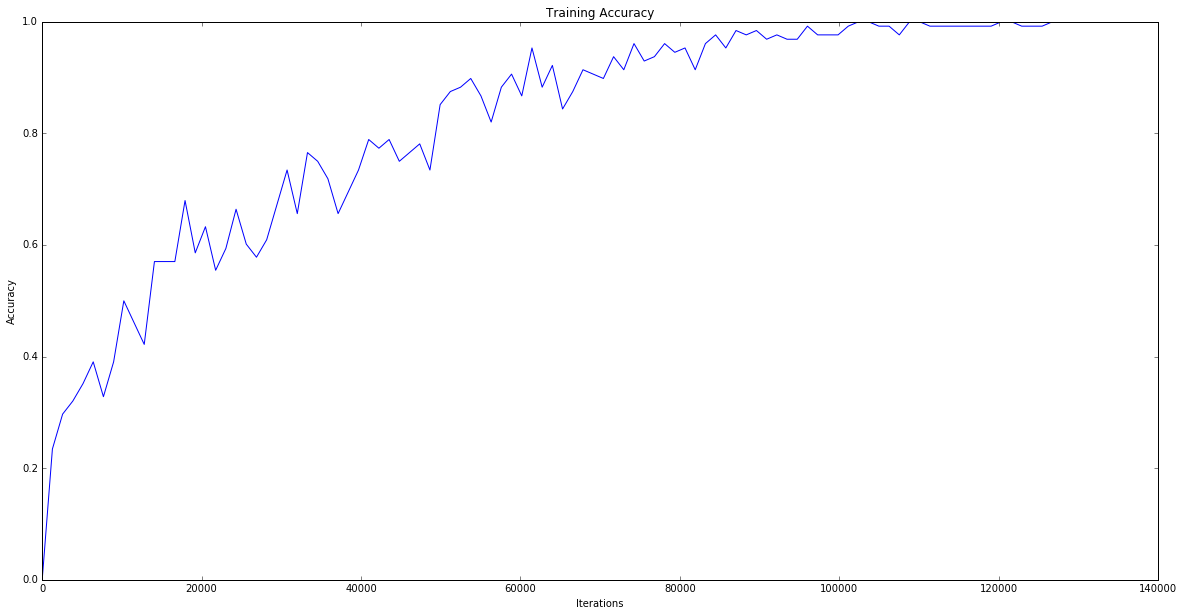

In [41]:
import pickle

with open('accs_file.pickle', 'rb') as handle:
    (accs, losses, iterations, testaccs) = pickle.load(handle)

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
x = iterations
y = accs
plt.title("Training Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(x, y)

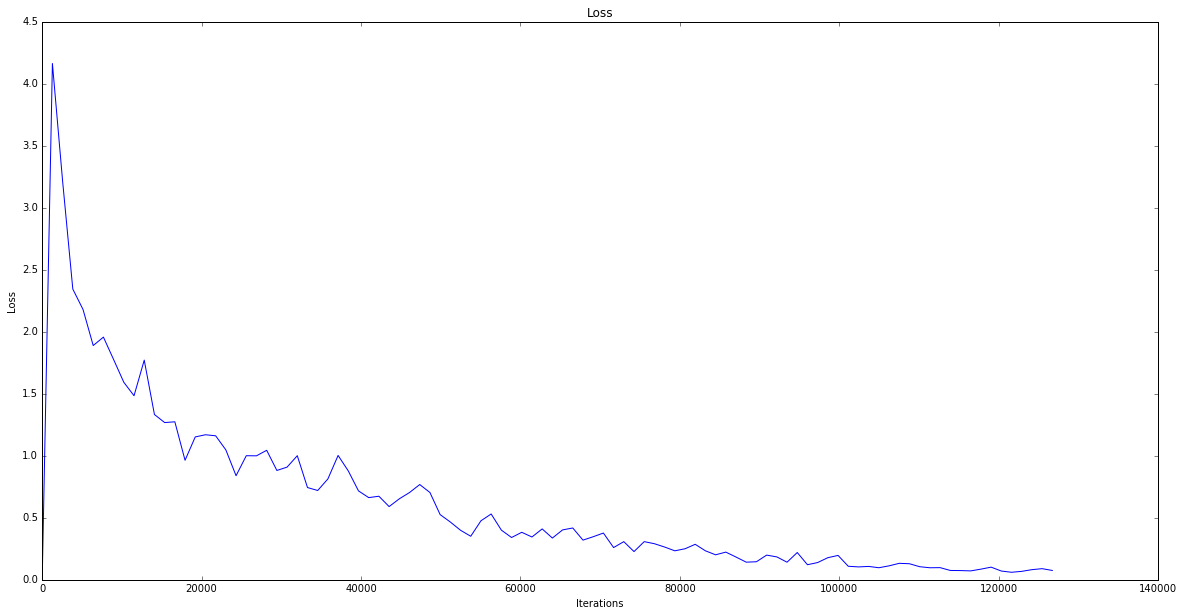

In [42]:
plt.figure(figsize=(20,10))
x = iterations
y = losses
plt.title("Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(x, y)

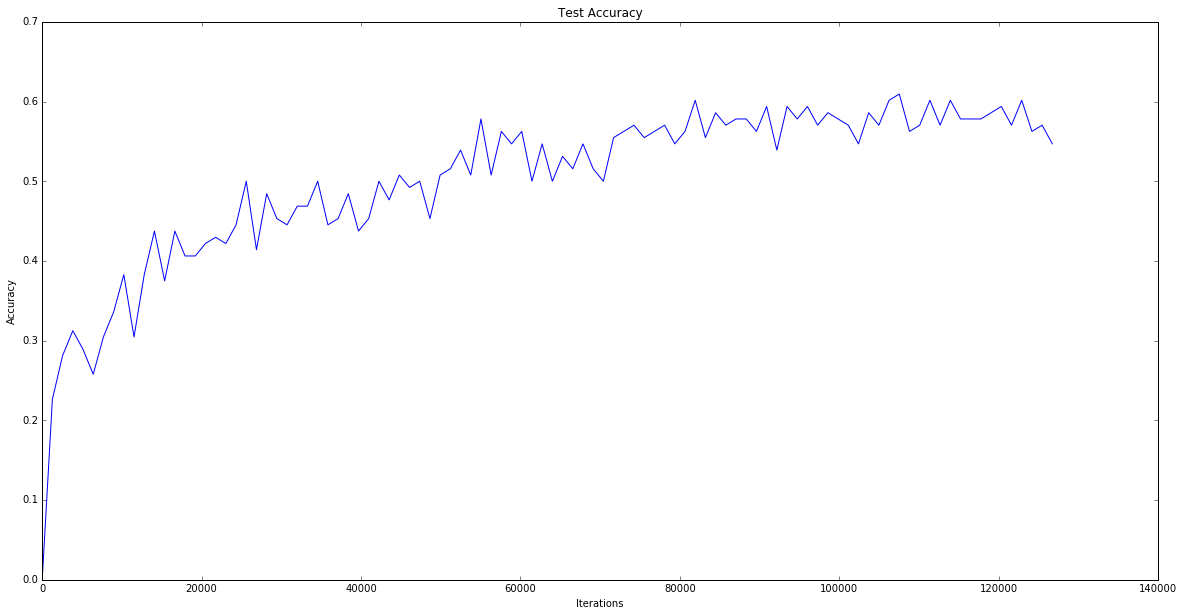

In [40]:
plt.figure(figsize=(20,10))
x = iterations
y = testaccs
plt.title("Test Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(x, y)

In [43]:
print testaccs

[ 0.         0.2265625  0.28125    0.3125     0.2890625  0.2578125
  0.3046875  0.3359375  0.3828125  0.3046875  0.3828125  0.4375     0.375
  0.4375     0.40625    0.40625    0.421875   0.4296875  0.421875
  0.4453125  0.5        0.4140625  0.484375   0.453125   0.4453125  0.46875
  0.46875    0.5        0.4453125  0.453125   0.484375   0.4375     0.453125
  0.5        0.4765625  0.5078125  0.4921875  0.5        0.453125
  0.5078125  0.515625   0.5390625  0.5078125  0.578125   0.5078125  0.5625
  0.546875   0.5625     0.5        0.546875   0.5        0.53125    0.515625
  0.546875   0.515625   0.5        0.5546875  0.5625     0.5703125
  0.5546875  0.5625     0.5703125  0.546875   0.5625     0.6015625
  0.5546875  0.5859375  0.5703125  0.578125   0.578125   0.5625     0.59375
  0.5390625  0.59375    0.578125   0.59375    0.5703125  0.5859375
  0.578125   0.5703125  0.546875   0.5859375  0.5703125  0.6015625
  0.609375   0.5625     0.5703125  0.6015625  0.5703125  0.6015625
  0.578125 

In [44]:
print iterations

[      0.    1280.    2560.    3840.    5120.    6400.    7680.    8960.
   10240.   11520.   12800.   14080.   15360.   16640.   17920.   19200.
   20480.   21760.   23040.   24320.   25600.   26880.   28160.   29440.
   30720.   32000.   33280.   34560.   35840.   37120.   38400.   39680.
   40960.   42240.   43520.   44800.   46080.   47360.   48640.   49920.
   51200.   52480.   53760.   55040.   56320.   57600.   58880.   60160.
   61440.   62720.   64000.   65280.   66560.   67840.   69120.   70400.
   71680.   72960.   74240.   75520.   76800.   78080.   79360.   80640.
   81920.   83200.   84480.   85760.   87040.   88320.   89600.   90880.
   92160.   93440.   94720.   96000.   97280.   98560.   99840.  101120.
  102400.  103680.  104960.  106240.  107520.  108800.  110080.  111360.
  112640.  113920.  115200.  116480.  117760.  119040.  120320.  121600.
  122880.  124160.  125440.  126720.]
